In [1]:
import os
import re
import json
import ast

from pathlib import Path
from copy import deepcopy
from datetime import date, datetime, timedelta


import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from pandarallel import pandarallel

import dgl
import torch

from transformers import AutoTokenizer, AutoModel

In [2]:
%matplotlib inline
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df_book = pd.read_csv('datasets/kaggle_books.csv', sep=";", error_bad_lines=False, encoding="latin-1")
df_ratings = pd.read_csv('datasets/kaggle_ratings.csv', sep=";", error_bad_lines=False, encoding="latin-1")
df_user = pd.read_csv('datasets/kaggle_users.csv', sep=";", error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/IPython/core/int

In [4]:
df_rating_new1 = df_ratings[df_ratings['ISBN'].isin(df_book['ISBN'])]
df_rating_new2 = df_rating_new1[df_rating_new1['User-ID'].isin(df_user['User-ID'])]

In [5]:
df_rating_new2.shape

(1031136, 3)

In [6]:
print("Shape of the Book DF is : ", df_book.shape)
df_book.head()

Shape of the Book DF is :  (271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
print("Shape of the Ratings DF is : ", df_ratings.shape)
df_ratings.head()

Shape of the Ratings DF is :  (1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
print("Shape of the User DF is : ", df_user.shape)
df_user.head()

Shape of the User DF is :  (278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [9]:
# df_book.columns
df_book.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L',], inplace=True)

In [10]:
df_user.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


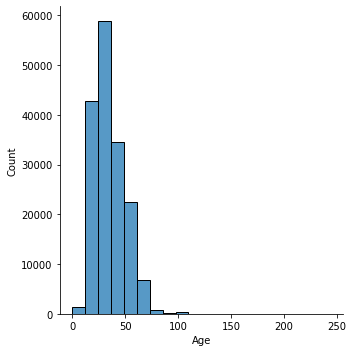

In [11]:
sns.displot(df_user['Age'], bins=20)

<AxesSubplot:xlabel='Age'>

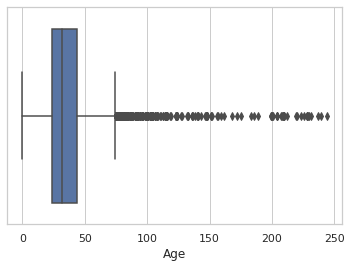

In [12]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=df_user["Age"])

In [13]:
def pre_process(string_value):
    sentence = str(string_value)
    cleantext = re.sub(r"[^a-zA-Z0-9]+", ' ', sentence.lower().strip())
    rem_url=re.sub(r'http\S+', '',cleantext)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_url)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    return " ".join(filtered_words)

In [14]:
df_book["authors"] = df_book['Book-Author'].parallel_apply(pre_process)

In [15]:
df_book["title"] = df_book['Book-Title'].parallel_apply(pre_process)

In [16]:
df_book["publishers"] = df_book['Publisher'].parallel_apply(pre_process)

In [17]:
df_book.rename(columns={"Year-Of-Publication": "publication_year"}, inplace=True)
df_book.drop(columns=['Book-Title', 'Book-Author', 'Publisher',], inplace=True)

In [18]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [19]:
df_user.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [20]:
df_user['location'] = df_user['Location'].parallel_apply(pre_process)

In [21]:
for index, row in df_user[df_user['Age'] > 119].iterrows():
    df_user['Age'][df_user.index == index] = row['Age'] * 0.1

<ipython-input-21-15c7c779215a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-21-15c7c779215a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-21-15c7c779215a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-21-15c7

In [22]:
# df_user['Age'].mode()
df_user['Age'].fillna(df_user['Age'].mode()[0], inplace=True)

In [23]:
df_user.isnull().sum()

User-ID     0
Location    0
Age         0
location    0
dtype: int64

In [38]:
df_rating_new2.reset_index(drop=True, inplace=True)
df_rat_rand = df_rating_new2.sample(frac=1, random_state=7)
training_test_index = round(len(df_rat_rand) * 0.7)
training_test_index

721795

In [39]:
training_set = df_rat_rand[:training_test_index].reset_index(drop=True)
test_set = df_rat_rand[training_test_index:].reset_index(drop=True)

In [40]:
#Removed enties of non existing user id and isbn from test not available in train

test_set_new = test_set[test_set['User-ID'].isin(training_set['User-ID']) &
                      test_set['ISBN'].isin(training_set['ISBN'])]

df_user = df_user[df_user['User-ID'].isin(training_set['User-ID'])]
df_book = df_book[df_book['ISBN'].isin(training_set['ISBN'])]

In [41]:
print("Shape of the test_set_new array = ", test_set_new.shape)
print("Shape of the df_user array = ", df_user.shape)
print("Shape of the training_set array = ", training_set.shape)
print("Shape of the df_book array = ", df_book.shape)

Shape of the test_set_new array =  (239130, 3)
Shape of the df_user array =  (64465, 4)
Shape of the training_set array =  (721795, 3)
Shape of the df_book array =  (185813, 5)


In [28]:
df_book.reset_index(drop=True, inplace=True)
df_user.reset_index(drop=True, inplace=True)
test_set_new.reset_index(drop=True, inplace=True)
training_set.reset_index(drop=True, inplace=True)

In [29]:
test_set_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255238 entries, 0 to 255237
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      255238 non-null  int64 
 1   ISBN         255238 non-null  object
 2   Book-Rating  255238 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.8+ MB


In [30]:
train_data = training_set.astype({'User-ID': 'category', 'ISBN': 'category'})
test_data = test_set_new.astype({'User-ID': 'category', 'ISBN': 'category'})

In [31]:
train_user_ids = torch.LongTensor(train_data['User-ID'].cat.codes.values)
train_item_ids = torch.LongTensor(train_data['ISBN'].cat.codes.values)
train_ratings = torch.LongTensor(train_data['Book-Rating'].values)
test_user_ids = torch.LongTensor(test_data['User-ID'].cat.codes.values)
test_item_ids = torch.LongTensor(test_data['ISBN'].cat.codes.values)
test_ratings = torch.LongTensor(test_data['Book-Rating'].values)

<ipython-input-31-d3058a5be1c0>:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755883846/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  train_user_ids = torch.LongTensor(train_data['User-ID'].cat.codes.values)


In [32]:
train_ratings

tensor([ 9, 10, 10,  ...,  0,  0,  0])

In [33]:
graph = dgl.heterograph({
    # Heterogeneous graphs are organized as a dictionary of edges connecting two types of nodes.
    # We specify the edges of a type simply with a pair of user ID array and item ID array.
    ('user', 'read', 'item'): (train_user_ids, train_item_ids),
    # Since DGL graphs are directional, we need an inverse relation from items to users as well.
    ('item', 'read-by', 'user'): (train_item_ids, train_user_ids)
})

In [34]:
graph

Graph(num_nodes={'item': 274875, 'user': 86105},
      num_edges={('item', 'read-by', 'user'): 804846, ('user', 'read', 'item'): 804846},
      metagraph=[('item', 'user', 'read-by'), ('user', 'item', 'read')])

DGLError: Invalid key "0". Must be one of the edge types.

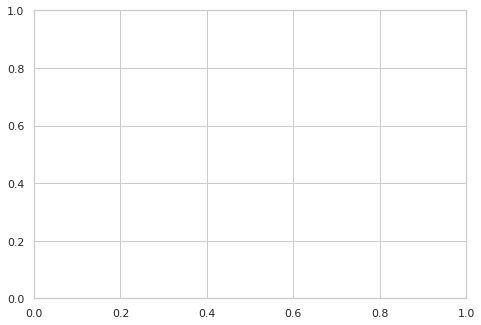

In [35]:
import networkx as nx

# The metagraph is shown in the figure below.  Note the bidirectional arrows.
# nx.draw_networkx_edges(graph.metagraph, )
nx.draw(graph)

In [36]:
df_user['User-ID'] = df_user['User-ID'].astype('category')
df_user['User-ID'] = df_user['User-ID'].cat.set_categories(train_data['User-ID'].cat.categories)

# df_user = df_user.dropna(subset=[0])
# df_user['User-ID'] = df_user['User-ID'].cat.codes
# df_user = df_user.sort_values('User-ID')

df_book['ISBN'] = df_book['ISBN'].astype('category')
df_book['ISBN'] = df_book['ISBN'].cat.set_categories(train_data['ISBN'].cat.categories)

# df_book = df_book.dropna(subset=[0])
# df_book['ISBN'] = df_book['ISBN'].cat.codes
# df_book = df_book.sort_values('ISBN')


In [ ]:
# Convert the age, gender, and occupation column to categorical
df_user['location'] = df_user['location'].astype('category')
df_user.drop(columns='Location', inplace=True)

user_age = df_user['Age'].values // 10
num_user_age_bins = user_age.max() + 1     # count the number of user age bins


In [ ]:
tf = TfidfVectorizer(ngram_range=(1,6), min_df = 0, stop_words = 'english', sublinear_tf=True)
tfidf_matrix_user_loc = tf.fit_transform(df_user['location'])

tfidf_matrix_user_loc

<86105x76654 sparse matrix of type '<class 'numpy.float64'>'
	with 657037 stored elements in Compressed Sparse Row format>

In [ ]:
loc_user = np.hstack(tfidf_matrix_user_loc)

In [ ]:
loc_user.shape

(86105,)

In [ ]:
df_book.isnull().sum()

ISBN                0
publication_year    0
authors             0
title               0
publishers          0
dtype: int64

In [ ]:
pd.to_numeric(df_book['publication_year'])

0         2002
1         2001
2         1991
3         1999
4         1999
          ... 
221094    2001
221095    2004
221096    1975
221097    1996
221098    2000
Name: publication_year, Length: 221099, dtype: int64

In [ ]:
# df_book[df_book['ISBN'] == '078946697X']

df_book.iloc[185938]

ISBN                                                       0789466953
publication_year                                                 2000
authors                                                 james buckley
title               readers creating men comic books come life lev...
publishers                                          dk publishing inc
Name: 185938, dtype: object

In [ ]:
df_book.at[176889, 'publishers'] = 'dk publishing inc'
df_book.at[176889, 'authors'] = 'michael teitelbaum'
df_book.at[176889, 'publication_year'] = '2000'
df_book.at[176889, 'title'] = 'readers creating men began level proficient readers'

In [ ]:
df_book.at[185248, 'publishers'] = 'gallimard'
df_book.at[185248, 'authors'] = 'suivi les bergers jean marie gustave zio'
df_book.at[185248, 'publication_year'] = '2003'
df_book.at[185248, 'title'] = 'peuple ciel'

In [ ]:
df_book.at[185938, 'publishers'] = 'dk publishing inc'
df_book.at[185938, 'authors'] = 'james buckley'
df_book.at[185938, 'publication_year'] = '2000'
df_book.at[185938, 'title'] = 'readers creating men comic books come life level proficient readers'

In [ ]:
cols = ['authors', 'publishers']
df_book['meta_info'] = df_book[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
tf_book = TfidfVectorizer(ngram_range=(1,6), min_df = 0, stop_words = 'english', sublinear_tf=True)
tfidf_matrix_book_meta = tf_book.fit_transform(df_book['meta_info'])

tfidf_matrix_book_meta.shape

(221099, 741318)

In [ ]:
meta_book = np.hstack(tfidf_matrix_book_meta)

In [ ]:
meta_book.shape

(221099,)

In [ ]:
user_age.shape

(86105,)

In [ ]:
# Assign user features
graph.nodes['user'].data['age'] = torch.LongTensor(user_age)


In [ ]:
graph.nodes['user'].data['location'] = torch.LongTensor(loc_user)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
df_book['publication_year'] = df_book['publication_year'].astype(int)

In [ ]:

# Assign item features
graph.nodes['item'].data['publish_year'] = torch.FloatTensor(df_book['publication_year'].values)
# Assign ratings
graph.edges['read'].data['rating'] = torch.LongTensor(train_ratings)
graph.edges['read-by'].data['rating'] = torch.LongTensor(train_ratings)

DGLError: Expect number of features to match number of nodes (len(u)). Got 221099 and 274875 instead.